# Pretty rendering of `rf_type.Tile` 

### Setup Spark Environment

In [1]:
from pyspark.sql import SparkSession
from pyrasterframes import *
from pyrasterframes.rasterfunctions import *

spark = SparkSession.builder \
    .withKryoSerialization() \
    .getOrCreate() \
    .withRasterFrames()

In [2]:
from pyrasterframes import RFContext
RFContext.active().build_info()

{'scalaVersion': '2.11.12', 'builtAtMillis': '1560432286838', 'sbtVersion': '1.2.8', 'name': 'core', 'rfSparkVersion': '2.3.2', 'moduleName': 'rasterframes', 'rfGeoMesaVersion': '2.2.1', 'rfGeoTrellisVersion': '2.2.0', 'version': '0.8.0-SNAPSHOT', 'builtAtString': '2019-06-13 13:24:46.838'}

## Read an EO raster source  

In [3]:
href1 = "https://modis-pds.s3.amazonaws.com/MCD43A4.006/31/11/2017158/MCD43A4.A2017158.h31v11.006.2017171203421_B01.TIF"

from pyspark.sql.functions import col
# this here contortion is to force the RasterRef to evaluate; and to get the tile type 
df = spark.read.rastersource(href1).withColumn('tile2', 
                                               rf_local_add_int(col('tile').tile, 0))

In [4]:
df.printSchema()

root
 |-- tile_path: string (nullable = false)
 |-- tile: struct (nullable = true)
 |    |-- tile_context: struct (nullable = false)
 |    |    |-- extent: struct (nullable = false)
 |    |    |    |-- xmin: double (nullable = false)
 |    |    |    |-- ymin: double (nullable = false)
 |    |    |    |-- xmax: double (nullable = false)
 |    |    |    |-- ymax: double (nullable = false)
 |    |    |-- crs: struct (nullable = false)
 |    |    |    |-- crsProj4: string (nullable = false)
 |    |-- tile: tile (nullable = false)
 |-- tile2: tile (nullable = true)



Boo!

In [5]:
df.show(3, False)

+--------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------+
|tile_path                                                                                                     |tile                                                                                                                                                                                                                   

# Make it pretty

To add this to the Tile class we can override `_repr_png_` (or `_repr_svg_` or others) to accomplish this.

In [6]:
def tile_to_png(t):
    # https://gist.github.com/rduplain/1641344
    import io
    from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
    from matplotlib.figure import Figure
    from matplotlib.pyplot import imshow

    fig=Figure()
    canvas=FigureCanvas(fig)
    
    axis =  fig.add_subplot(1,1,1)
    array = t.cells

    axis.imshow(array)
    
    output = io.BytesIO()
    canvas.print_png(output)
    return output.getvalue()

In [7]:
# https://ipython.readthedocs.io/en/stable/config/integrating.html#integrating-rich-display
# https://ipython.readthedocs.io/en/stable/config/integrating.html#formatters-for-third-party-types
import pyrasterframes.rf_types
png_formatter = get_ipython().display_formatter.formatters['image/png']
png_formatter.for_type(pyrasterframes.rf_types.Tile, tile_to_png)

Get a tile, I'm from Missouri!

In [8]:
tile = df.select(df.tile2).first().tile2

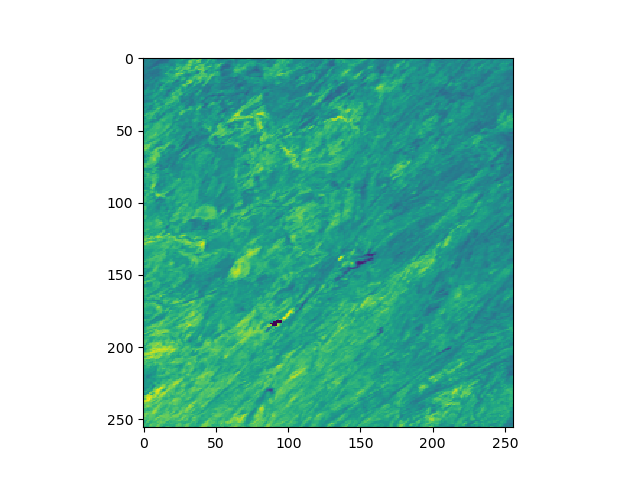

In [9]:
tile

Boom!

# Now do it with Pandas DF

In [10]:
pandas_df = df.select(rf_crs(df.tile), 
                      rf_extent(df.tile), 
                      df.tile2).limit(10).toPandas()

In [11]:
def tile_to_html(t):
    import base64
    b64_img_html = '<img src="data:image/png;base64,{}" />'
    
    bitz = tile_to_png(t)
    b64_img = base64.b64encode(bitz).decode('utf-8').replace('\n', '')
    return b64_img_html.format(b64_img)

This is less general as we have to construct this call each time... Also need to enforce this max col width option.


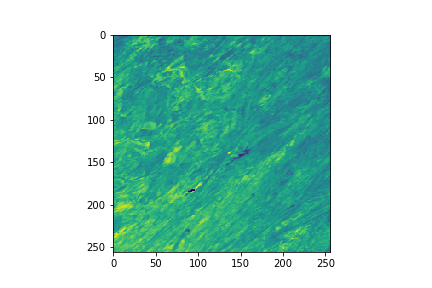
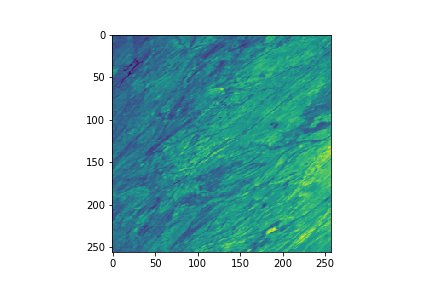
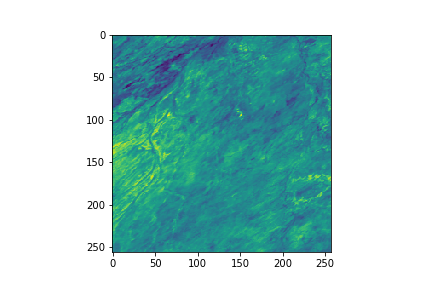
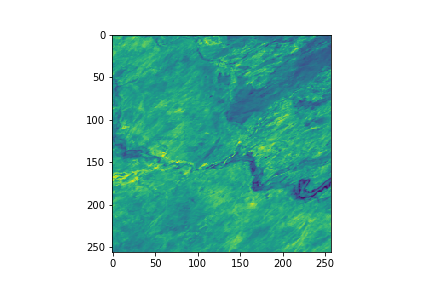
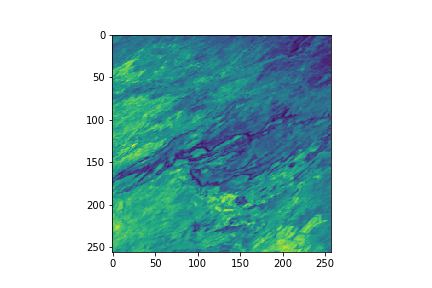
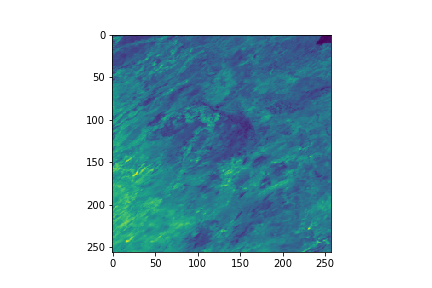
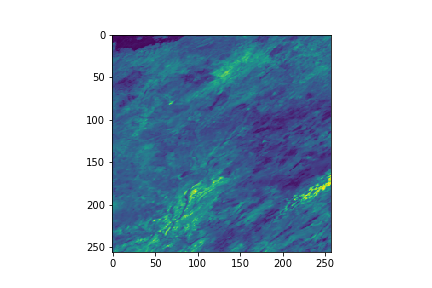
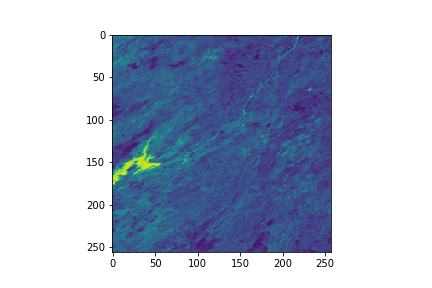
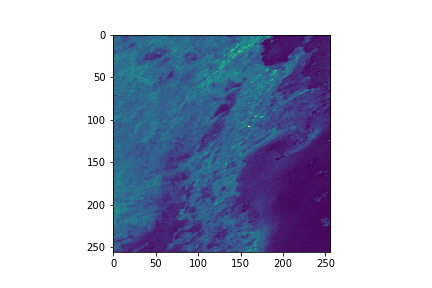
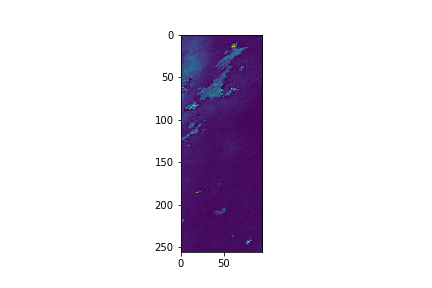

In [12]:
from IPython.display import HTML
import pandas as pd
pd.options.display.max_colwidth = -1
HTML(pandas_df.to_html(escape=False, formatters=dict(tile2=tile_to_html)))

In [13]:
# Default viz remains
pandas_df

rf_crs(tile)  \
0  (+proj=sinu +lon_0=0.0 +x_0=0.0 +y_0=0.0 +a=6371007.181 +b=6371007.181 +units=m ,)   
1  (+proj=sinu +lon_0=0.0 +x_0=0.0 +y_0=0.0 +a=6371007.181 +b=6371007.181 +units=m ,)   
2  (+proj=sinu +lon_0=0.0 +x_0=0.0 +y_0=0.0 +a=6371007.181 +b=6371007.181 +units=m ,)   
3  (+proj=sinu +lon_0=0.0 +x_0=0.0 +y_0=0.0 +a=6371007.181 +b=6371007.181 +units=m ,)   
4  (+proj=sinu +lon_0=0.0 +x_0=0.0 +y_0=0.0 +a=6371007.181 +b=6371007.181 +units=m ,)   
5  (+proj=sinu +lon_0=0.0 +x_0=0.0 +y_0=0.0 +a=6371007.181 +b=6371007.181 +units=m ,)   
6  (+proj=sinu +lon_0=0.0 +x_0=0.0 +y_0=0.0 +a=6371007.181 +b=6371007.181 +units=m ,)   
7  (+proj=sinu +lon_0=0.0 +x_0=0.0 +y_0=0.0 +a=6371007.181 +b=6371007.181 +units=m ,)   
8  (+proj=sinu +lon_0=0.0 +x_0=0.0 +y_0=0.0 +a=6371007.181 +b=6371007.181 +units=m ,)   
9  (+proj=sinu +lon_0=0.0 +x_0=0.0 +y_0=0.0 +a=6371007.181 +b=6371007.181 +units=m ,)   

                                                                  rf_extent(tile)  \
0  (14455356.755667, -2342509.0947641465, 14573964.811098041, -2223901.039333)      
1  (14573964.81109804, -2342509.0947641465, 14692572.866529081, -2223901.039333)    
2  (14692572.86652908, -2342509.0947641465, 14811180.921960121, -2223901.039333)    
3  (14811180.92196012, -2342509.0947641465, 14929788.977391161, -2223901.039333)    
4  (14929788.97739116, -2342509.0947641465, 15048397.032822201, -2223901.039333)    
5  (15048397.0328222, -2342509.0947641465, 15167005.088253241, -2223901.039333)     
6  (15167005.08825324, -2342509.0947641465, 15285613.143684281, -2223901.039333)    
7  (15285613.14368428, -2342509.0947641465, 15404221.199115321, -2223901.039333)    
8  (15404221.199115321, -2342509.0947641465, 15522829.254546361, -2223901.039333)   
9  (15522829.254546361, -2342509.0947641465, 15567307.275333002, -2223901.039333)   

                                                                                                                                                                                                                                                                                                                   tile2  
0  Tile(dimensions=[256, 256], cell_type=CellType(int16ud32767, 32767), cells=[[1225 1244 1247 ... 1305 1245 1206]\n [1166 1188 1190 ... 1381 1251 1193]\n [1156 1110 1122 ... 1248 1245 1270]\n ...\n [1485 1749 1761 ... 1034  996  998]\n [1780 1777 1663 ... 1008 1027 1174]\n [1728 1647 1562 ... 1189 1297 1382]])  
1  Tile(dimensions=[257, 256], cell_type=CellType(int16ud32767, 32767), cells=[[1206 1140 1227 ... 1733 1610 1558]\n [1193 1158 1115 ... 1602 1759 1824]\n [1270 1154 1070 ... 1815 1753 1845]\n ...\n [ 998 1085 1166 ... 1758 1755 1701]\n [1174 1302 1292 ... 1756 1682 1602]\n [1382 1288 1209 ... 1689 1561 1515]])  
2  Tile(dimensions=[257, 256], cell_type=CellType(int16ud32767, 32767), cells=[[1558 1546 1445 ... 1690 1691 1715]\n [1824 1783 1762 ... 1815 1796 1779]\n [1845 1773 1656 ... 1717 1745 1836]\n ...\n [1701 1623 1620 ... 1402 1352 1442]\n [1602 1630 1627 ... 1374 1417 1420]\n [1515 1523 1485 ... 1407 1369 1310]])  
3  Tile(dimensions=[257, 256], cell_type=CellType(int16ud32767, 32767), cells=[[1715 1765 1675 ... 1101 1140 1149]\n [1779 1800 1814 ... 1181 1212 1240]\n [1836 1801 1779 ... 1062 1213 1230]\n ...\n [1442 1478 1446 ... 1789 1748 1740]\n [1420 1384 1353 ... 1745 1730 1741]\n [1310 1228 1276 ... 1728 1734 1684]])  
4  Tile(dimensions=[257, 256], cell_type=CellType(int16ud32767, 32767), cells=[[1149 1171 1272 ...  613  617  622]\n [1240 1274 1284 ...  685  639  651]\n [1230 1226 1173 ...  669  649  634]\n ...\n [1740 1776 1686 ... 1216 1169 1116]\n [1741 1666 1536 ... 1185 1066 1094]\n [1684 1527 1577 ... 1085 1102 1091]])  
5  Tile(dimensions=[257, 256], cell_type=CellType(int16ud32767, 32767), cells=[[ 622  626  627 ...  364  283  248]\n [ 651  673  702 ...  264  246  248]\n [ 634  775  771 ...  246  260  265]\n ...\n [1116 1098 1101 ...  971  926  939]\n [1094 1093 1114 ... 1013 1021 

In [27]:
def pd_tile_to_html(dataframe):
    from IPython.display import HTML
    import pandas as pd
    pd.options.display.max_colwidth = -1
    
    tile_cols = []
    for c in dataframe.columns:
        if isinstance(dataframe.iloc[0][c], pyrasterframes.rf_types.Tile):
            tile_cols.append(c)
    # dict keyed by column with custome rendering function
    formatter = {c: tile_to_html for c in tile_cols}
    return dataframe.to_html(escape=False, formatters=formatter)

In [28]:
# this would possibly be able to be in an import  scenario?
html_formatter = get_ipython().display_formatter.formatters['text/html']
html_formatter.for_type(pd.DataFrame, pd_tile_to_html)

<function __main__.pd_tile_to_html(dataframe)>

rf_crs(tile)  \
0  (+proj=sinu +lon_0=0.0 +x_0=0.0 +y_0=0.0 +a=6371007.181 +b=6371007.181 +units=m ,)   
1  (+proj=sinu +lon_0=0.0 +x_0=0.0 +y_0=0.0 +a=6371007.181 +b=6371007.181 +units=m ,)   
2  (+proj=sinu +lon_0=0.0 +x_0=0.0 +y_0=0.0 +a=6371007.181 +b=6371007.181 +units=m ,)   
3  (+proj=sinu +lon_0=0.0 +x_0=0.0 +y_0=0.0 +a=6371007.181 +b=6371007.181 +units=m ,)   
4  (+proj=sinu +lon_0=0.0 +x_0=0.0 +y_0=0.0 +a=6371007.181 +b=6371007.181 +units=m ,)   
5  (+proj=sinu +lon_0=0.0 +x_0=0.0 +y_0=0.0 +a=6371007.181 +b=6371007.181 +units=m ,)   
6  (+proj=sinu +lon_0=0.0 +x_0=0.0 +y_0=0.0 +a=6371007.181 +b=6371007.181 +units=m ,)   
7  (+proj=sinu +lon_0=0.0 +x_0=0.0 +y_0=0.0 +a=6371007.181 +b=6371007.181 +units=m ,)   
8  (+proj=sinu +lon_0=0.0 +x_0=0.0 +y_0=0.0 +a=6371007.181 +b=6371007.181 +units=m ,)   
9  (+proj=sinu +lon_0=0.0 +x_0=0.0 +y_0=0.0 +a=6371007.181 +b=6371007.181 +units=m ,)   

                                                                  rf_extent(tile)  \
0  (14455356.755667, -2342509.0947641465, 14573964.811098041, -2223901.039333)      
1  (14573964.81109804, -2342509.0947641465, 14692572.866529081, -2223901.039333)    
2  (14692572.86652908, -2342509.0947641465, 14811180.921960121, -2223901.039333)    
3  (14811180.92196012, -2342509.0947641465, 14929788.977391161, -2223901.039333)    
4  (14929788.97739116, -2342509.0947641465, 15048397.032822201, -2223901.039333)    
5  (15048397.0328222, -2342509.0947641465, 15167005.088253241, -2223901.039333)     
6  (15167005.08825324, -2342509.0947641465, 15285613.143684281, -2223901.039333)    
7  (15285613.14368428, -2342509.0947641465, 15404221.199115321, -2223901.039333)    
8  (15404221.199115321, -2342509.0947641465, 15522829.254546361, -2223901.039333)   
9  (15522829.254546361, -2342509.0947641465, 15567307.275333002, -2223901.039333)   

                                                                                                                                                                                                                                                                                                                   tile2  
0  Tile(dimensions=[256, 256], cell_type=CellType(int16ud32767, 32767), cells=[[1225 1244 1247 ... 1305 1245 1206]\n [1166 1188 1190 ... 1381 1251 1193]\n [1156 1110 1122 ... 1248 1245 1270]\n ...\n [1485 1749 1761 ... 1034  996  998]\n [1780 1777 1663 ... 1008 1027 1174]\n [1728 1647 1562 ... 1189 1297 1382]])  
1  Tile(dimensions=[257, 256], cell_type=CellType(int16ud32767, 32767), cells=[[1206 1140 1227 ... 1733 1610 1558]\n [1193 1158 1115 ... 1602 1759 1824]\n [1270 1154 1070 ... 1815 1753 1845]\n ...\n [ 998 1085 1166 ... 1758 1755 1701]\n [1174 1302 1292 ... 1756 1682 1602]\n [1382 1288 1209 ... 1689 1561 1515]])  
2  Tile(dimensions=[257, 256], cell_type=CellType(int16ud32767, 32767), cells=[[1558 1546 1445 ... 1690 1691 1715]\n [1824 1783 1762 ... 1815 1796 1779]\n [1845 1773 1656 ... 1717 1745 1836]\n ...\n [1701 1623 1620 ... 1402 1352 1442]\n [1602 1630 1627 ... 1374 1417 1420]\n [1515 1523 1485 ... 1407 1369 1310]])  
3  Tile(dimensions=[257, 256], cell_type=CellType(int16ud32767, 32767), cells=[[1715 1765 1675 ... 1101 1140 1149]\n [1779 1800 1814 ... 1181 1212 1240]\n [1836 1801 1779 ... 1062 1213 1230]\n ...\n [1442 1478 1446 ... 1789 1748 1740]\n [1420 1384 1353 ... 1745 1730 1741]\n [1310 1228 1276 ... 1728 1734 1684]])  
4  Tile(dimensions=[257, 256], cell_type=CellType(int16ud32767, 32767), cells=[[1149 1171 1272 ...  613  617  622]\n [1240 1274 1284 ...  685  639  651]\n [1230 1226 1173 ...  669  649  634]\n ...\n [1740 1776 1686 ... 1216 1169 1116]\n [1741 1666 1536 ... 1185 1066 1094]\n [1684 1527 1577 ... 1085 1102 1091]])  
5  Tile(dimensions=[257, 256], cell_type=CellType(int16ud32767, 32767), cells=[[ 622  626  627 ...  364  283  248]\n [ 651  673  702 ...  264  246  248]\n [ 634  775  771 ...  246  260  265]\n ...\n [1116 1098 1101 ...  971  926  939]\n [1094 1093 1114 ... 1013 1021 
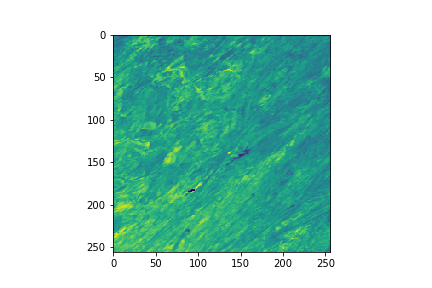
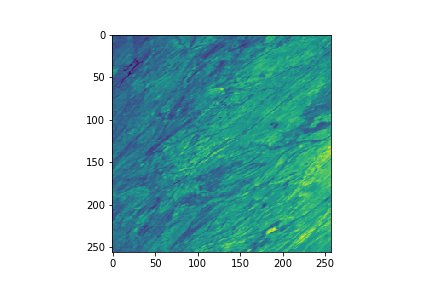
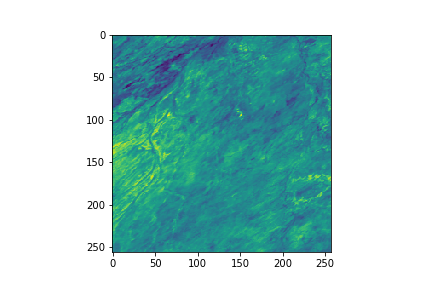
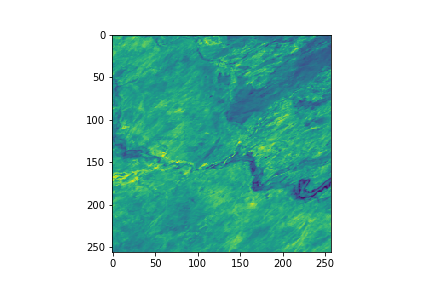
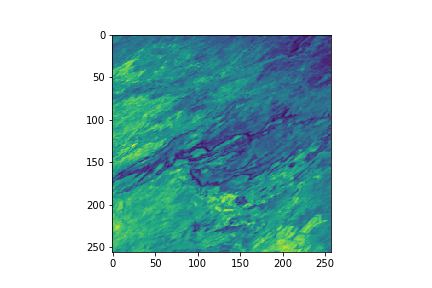
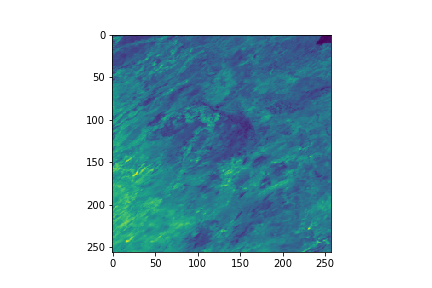
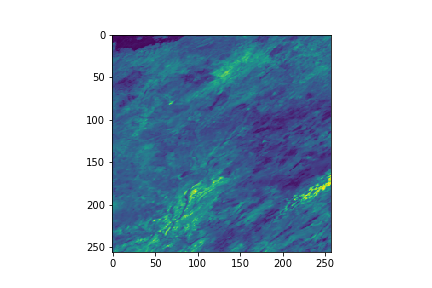
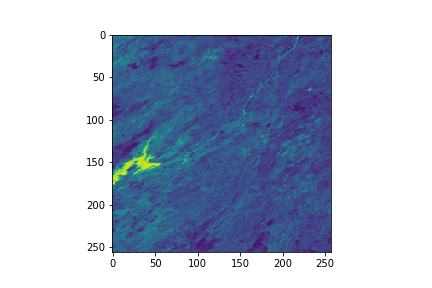
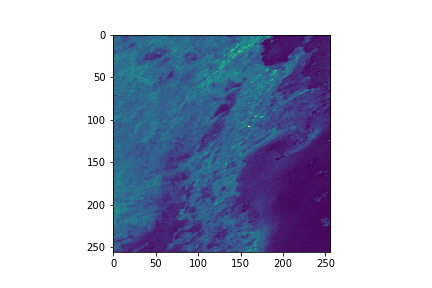
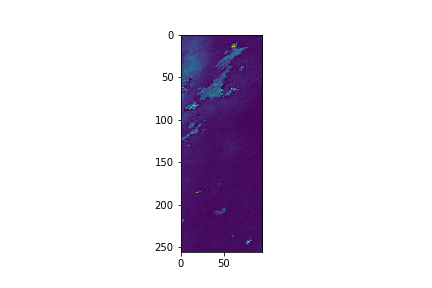

In [29]:
pandas_df

rf_crs(tile)  \
0  (+proj=sinu +lon_0=0.0 +x_0=0.0 +y_0=0.0 +a=6371007.181 +b=6371007.181 +units=m ,)   
1  (+proj=sinu +lon_0=0.0 +x_0=0.0 +y_0=0.0 +a=6371007.181 +b=6371007.181 +units=m ,)   
2  (+proj=sinu +lon_0=0.0 +x_0=0.0 +y_0=0.0 +a=6371007.181 +b=6371007.181 +units=m ,)   
3  (+proj=sinu +lon_0=0.0 +x_0=0.0 +y_0=0.0 +a=6371007.181 +b=6371007.181 +units=m ,)   
4  (+proj=sinu +lon_0=0.0 +x_0=0.0 +y_0=0.0 +a=6371007.181 +b=6371007.181 +units=m ,)   
5  (+proj=sinu +lon_0=0.0 +x_0=0.0 +y_0=0.0 +a=6371007.181 +b=6371007.181 +units=m ,)   
6  (+proj=sinu +lon_0=0.0 +x_0=0.0 +y_0=0.0 +a=6371007.181 +b=6371007.181 +units=m ,)   
7  (+proj=sinu +lon_0=0.0 +x_0=0.0 +y_0=0.0 +a=6371007.181 +b=6371007.181 +units=m ,)   
8  (+proj=sinu +lon_0=0.0 +x_0=0.0 +y_0=0.0 +a=6371007.181 +b=6371007.181 +units=m ,)   
9  (+proj=sinu +lon_0=0.0 +x_0=0.0 +y_0=0.0 +a=6371007.181 +b=6371007.181 +units=m ,)   

                                                                  rf_extent(tile)  \
0  (14455356.755667, -2342509.0947641465, 14573964.811098041, -2223901.039333)      
1  (14573964.81109804, -2342509.0947641465, 14692572.866529081, -2223901.039333)    
2  (14692572.86652908, -2342509.0947641465, 14811180.921960121, -2223901.039333)    
3  (14811180.92196012, -2342509.0947641465, 14929788.977391161, -2223901.039333)    
4  (14929788.97739116, -2342509.0947641465, 15048397.032822201, -2223901.039333)    
5  (15048397.0328222, -2342509.0947641465, 15167005.088253241, -2223901.039333)     
6  (15167005.08825324, -2342509.0947641465, 15285613.143684281, -2223901.039333)    
7  (15285613.14368428, -2342509.0947641465, 15404221.199115321, -2223901.039333)    
8  (15404221.199115321, -2342509.0947641465, 15522829.254546361, -2223901.039333)   
9  (15522829.254546361, -2342509.0947641465, 15567307.275333002, -2223901.039333)   

                                                                                                                                                                                                                                                                                                                   tile2  \
0  Tile(dimensions=[256, 256], cell_type=CellType(int16ud32767, 32767), cells=[[1225 1244 1247 ... 1305 1245 1206]\n [1166 1188 1190 ... 1381 1251 1193]\n [1156 1110 1122 ... 1248 1245 1270]\n ...\n [1485 1749 1761 ... 1034  996  998]\n [1780 1777 1663 ... 1008 1027 1174]\n [1728 1647 1562 ... 1189 1297 1382]])   
1  Tile(dimensions=[257, 256], cell_type=CellType(int16ud32767, 32767), cells=[[1206 1140 1227 ... 1733 1610 1558]\n [1193 1158 1115 ... 1602 1759 1824]\n [1270 1154 1070 ... 1815 1753 1845]\n ...\n [ 998 1085 1166 ... 1758 1755 1701]\n [1174 1302 1292 ... 1756 1682 1602]\n [1382 1288 1209 ... 1689 1561 1515]])   
2  Tile(dimensions=[257, 256], cell_type=CellType(int16ud32767, 32767), cells=[[1558 1546 1445 ... 1690 1691 1715]\n [1824 1783 1762 ... 1815 1796 1779]\n [1845 1773 1656 ... 1717 1745 1836]\n ...\n [1701 1623 1620 ... 1402 1352 1442]\n [1602 1630 1627 ... 1374 1417 1420]\n [1515 1523 1485 ... 1407 1369 1310]])   
3  Tile(dimensions=[257, 256], cell_type=CellType(int16ud32767, 32767), cells=[[1715 1765 1675 ... 1101 1140 1149]\n [1779 1800 1814 ... 1181 1212 1240]\n [1836 1801 1779 ... 1062 1213 1230]\n ...\n [1442 1478 1446 ... 1789 1748 1740]\n [1420 1384 1353 ... 1745 1730 1741]\n [1310 1228 1276 ... 1728 1734 1684]])   
4  Tile(dimensions=[257, 256], cell_type=CellType(int16ud32767, 32767), cells=[[1149 1171 1272 ...  613  617  622]\n [1240 1274 1284 ...  685  639  651]\n [1230 1226 1173 ...  669  649  634]\n ...\n [1740 1776 1686 ... 1216 1169 1116]\n [1741 1666 1536 ... 1185 1066 1094]\n [1684 1527 1577 ... 1085 1102 1091]])   
5  Tile(dimensions=[257, 256], cell_type=CellType(int16ud32767, 32767), cells=[[ 622  626  627 ...  364  283  248]\n [ 651  673  702 ...  264  246  248]\n [ 634  775  771 ...  246  260  265]\n ...\n [1116 1098 1101 ...  971  926  939]\n [1094 1093 1114 ... 1013
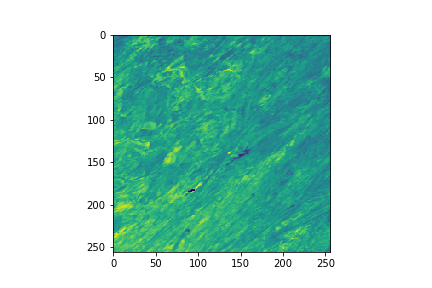
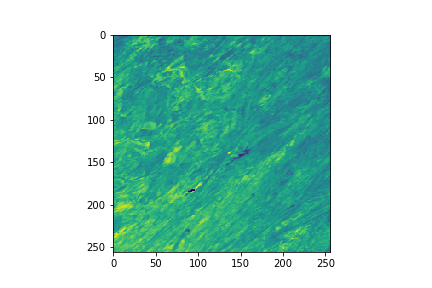
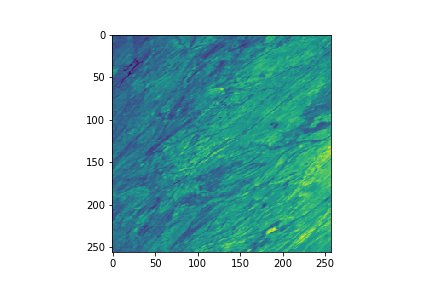
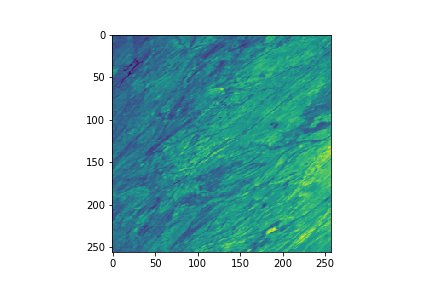
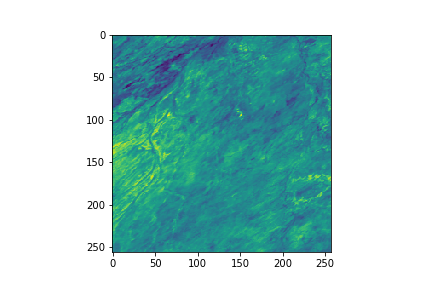
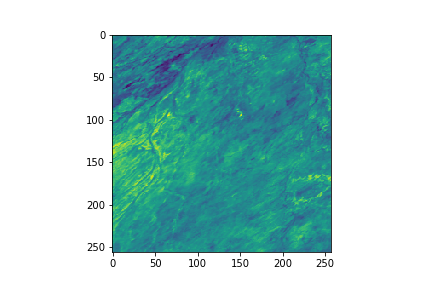
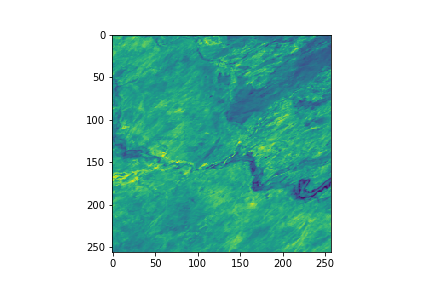
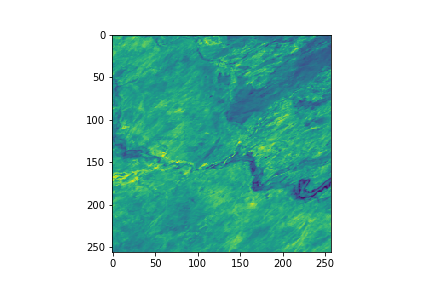
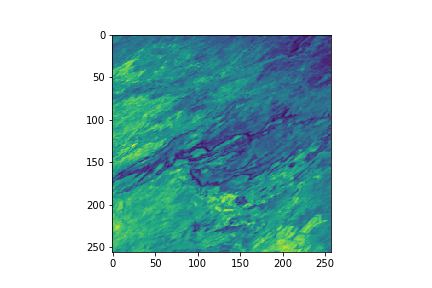
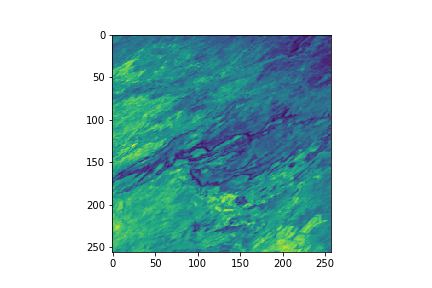
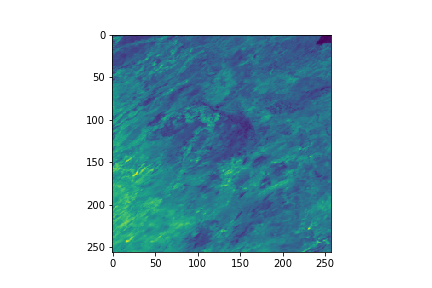
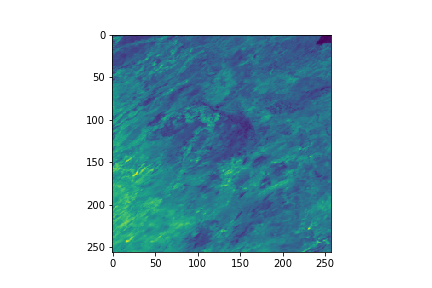
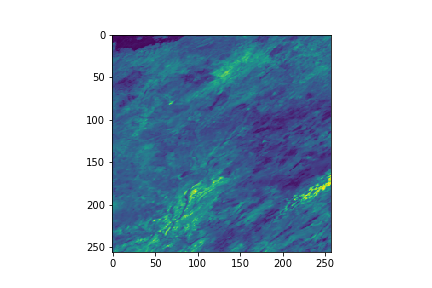
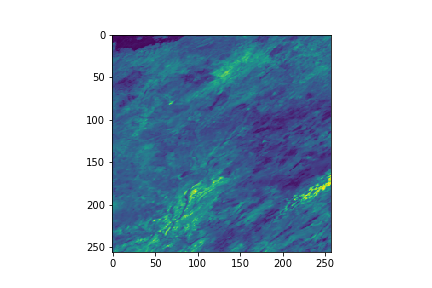
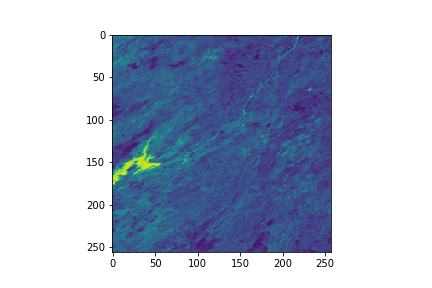
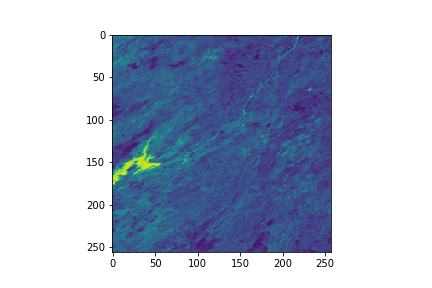
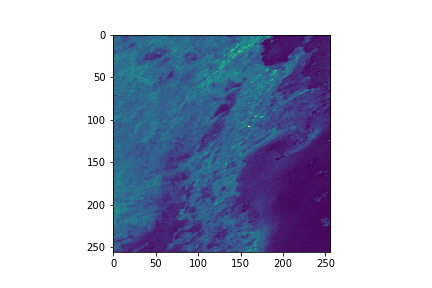
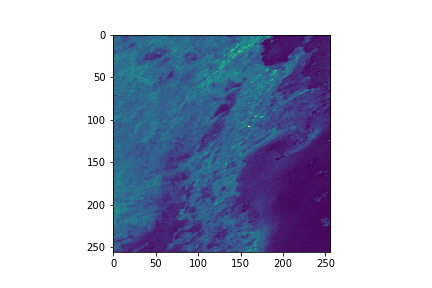
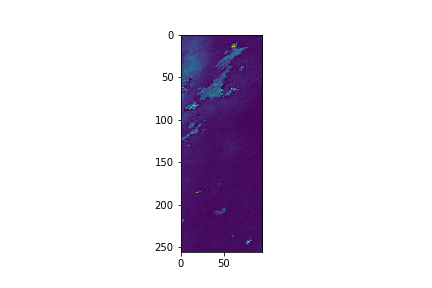
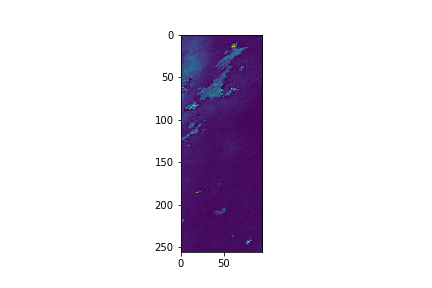

In [31]:
pandas_df['threex'] = pandas_df.tile2.apply(lambda t: t * 3)
pandas_df